In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
# from joblib import dump
import joblib
import warnings
import statsmodels.api as sm
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import wandb
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
style_dir='../../../styles'
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [4]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [5]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [7]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


lr = 0.0001


features = len(X_train.columns)



# Khởi tạo mô hình Sequential
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=(features, 1)))

model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='linear'))



# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 100, 32)           128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                102464    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 102657 (401.00 KB)
Trainable params: 102657 (401.00 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.hdf5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [11]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16969/16982 [============================>.] - ETA: 0s - loss: 0.4771 - mae: 0.4771 - r2: -1.1281INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 1: val_loss improved from inf to 0.21433, saving model to best_model.hdf5
16982/16982 [==============================] - 46s 3ms/step - loss: 0.4771 - mae: 0.4771 - r2: -1.1273 - val_loss: 0.2143 - val_mae: 0.2143 - val_r2: 0.6114 - lr: 1.0000e-04
Epoch 2/10000
16962/16982 [============================>.] - ETA: 0s - loss: 0.4073 - mae: 0.4073 - r2: -0.0540
Epoch 2: val_loss did not improve from 0.21433
16982/16982 [==============================] - 43s 3ms/step - loss: 0.4071 - mae: 0.4071 - r2: -0.0531 - val_loss: 0.2909 - val_mae: 0.2909 - val_r2: 0.6106 - lr: 1.0000e-04
Epoch 3/10000
16961/16982 [============================>.] - ETA: 0s - loss: 0.3383 - mae: 0.3383 - r2: 0.2179
Epoch 3: val_loss did not improve from 0.21433
16982/16982 [==============================] - 42s 2ms/step - loss: 0.3383 - mae: 0.3383 - r2: 0.2177 - val_loss: 0.6067 - val_mae: 0.6067 - val_r2: -0.4886 - lr: 1.0000e-04
Epoch 4/10000
16964/16982 [============================>.] - ETA: 0s - loss: 0.2

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 6: val_loss improved from 0.21433 to 0.14963, saving model to best_model.hdf5
16982/16982 [==============================] - 45s 3ms/step - loss: 0.2205 - mae: 0.2205 - r2: 0.6035 - val_loss: 0.1496 - val_mae: 0.1496 - val_r2: 0.7922 - lr: 1.0000e-04
Epoch 7/10000
16972/16982 [============================>.] - ETA: 0s - loss: 0.1989 - mae: 0.1989 - r2: 0.6535
Epoch 7: val_loss did not improve from 0.14963
16982/16982 [==============================] - 42s 2ms/step - loss: 0.1989 - mae: 0.1989 - r2: 0.6535 - val_loss: 0.4710 - val_mae: 0.4710 - val_r2: 0.0081 - lr: 1.0000e-04
Epoch 8/10000
16959/16982 [============================>.] - ETA: 0s - loss: 0.1842 - mae: 0.1842 - r2: 0.6819INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 8: val_loss improved from 0.14963 to 0.10552, saving model to best_model.hdf5
16982/16982 [==============================] - 44s 3ms/step - loss: 0.1842 - mae: 0.1842 - r2: 0.6820 - val_loss: 0.1055 - val_mae: 0.1055 - val_r2: 0.8765 - lr: 1.0000e-04
Epoch 9/10000
16966/16982 [============================>.] - ETA: 0s - loss: 0.1682 - mae: 0.1682 - r2: 0.7184
Epoch 9: val_loss did not improve from 0.10552
16982/16982 [==============================] - 43s 3ms/step - loss: 0.1682 - mae: 0.1682 - r2: 0.7185 - val_loss: 0.1671 - val_mae: 0.1671 - val_r2: 0.7314 - lr: 1.0000e-04
Epoch 10/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1616 - mae: 0.1616 - r2: 0.7244
Epoch 10: val_loss did not improve from 0.10552
16982/16982 [==============================] - 43s 3ms/step - loss: 0.1616 - mae: 0.1616 - r2: 0.7244 - val_loss: 0.3351 - val_mae: 0.3351 - val_r2: 0.3745 - lr: 1.0000e-04
Epoch 11/10000
16963/16982 [============================>.] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 19: val_loss improved from 0.10552 to 0.09685, saving model to best_model.hdf5
16982/16982 [==============================] - 44s 3ms/step - loss: 0.1041 - mae: 0.1041 - r2: 0.8041 - val_loss: 0.0968 - val_mae: 0.0968 - val_r2: 0.8735 - lr: 5.0000e-05
Epoch 20/10000
16973/16982 [============================>.] - ETA: 0s - loss: 0.1033 - mae: 0.1033 - r2: 0.8046INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 20: val_loss improved from 0.09685 to 0.09674, saving model to best_model.hdf5
16982/16982 [==============================] - 43s 3ms/step - loss: 0.1033 - mae: 0.1033 - r2: 0.8046 - val_loss: 0.0967 - val_mae: 0.0967 - val_r2: 0.8681 - lr: 5.0000e-05
Epoch 21/10000
16968/16982 [============================>.] - ETA: 0s - loss: 0.1025 - mae: 0.1025 - r2: 0.8066
Epoch 21: val_loss did not improve from 0.09674
16982/16982 [==============================] - 42s 2ms/step - loss: 0.1025 - mae: 0.1025 - r2: 0.8067 - val_loss: 0.1127 - val_mae: 0.1127 - val_r2: 0.8348 - lr: 5.0000e-05
Epoch 22/10000
16979/16982 [============================>.] - ETA: 0s - loss: 0.1016 - mae: 0.1016 - r2: 0.8090
Epoch 22: val_loss did not improve from 0.09674
16982/16982 [==============================] - 43s 3ms/step - loss: 0.1016 - mae: 0.1016 - r2: 0.8090 - val_loss: 0.1128 - val_mae: 0.1128 - val_r2: 0.8492 - lr: 5.0000e-05
Epoch 23/10000
16976/16982 [============================>.] - ETA: 0s - los

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\CNNs\wandb\run-20240715_225635-e669hu8x\files\model-best)... Done. 0.0s



Epoch 31: val_loss improved from 0.09674 to 0.09051, saving model to best_model.hdf5
16982/16982 [==============================] - 43s 3ms/step - loss: 0.0896 - mae: 0.0896 - r2: 0.8166 - val_loss: 0.0905 - val_mae: 0.0905 - val_r2: 0.8958 - lr: 2.5000e-05
Epoch 32/10000
16967/16982 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.0893 - r2: 0.8196
Epoch 32: val_loss did not improve from 0.09051
16982/16982 [==============================] - 42s 2ms/step - loss: 0.0893 - mae: 0.0893 - r2: 0.8196 - val_loss: 0.1000 - val_mae: 0.1000 - val_r2: 0.8751 - lr: 2.5000e-05
Epoch 33/10000
16967/16982 [============================>.] - ETA: 0s - loss: 0.0892 - mae: 0.0892 - r2: 0.8202
Epoch 33: val_loss did not improve from 0.09051
16982/16982 [==============================] - 42s 2ms/step - loss: 0.0892 - mae: 0.0892 - r2: 0.8202 - val_loss: 0.0997 - val_mae: 0.0997 - val_r2: 0.8797 - lr: 2.5000e-05
Epoch 34/10000
16970/16982 [============================>.] - ETA: 0s - los

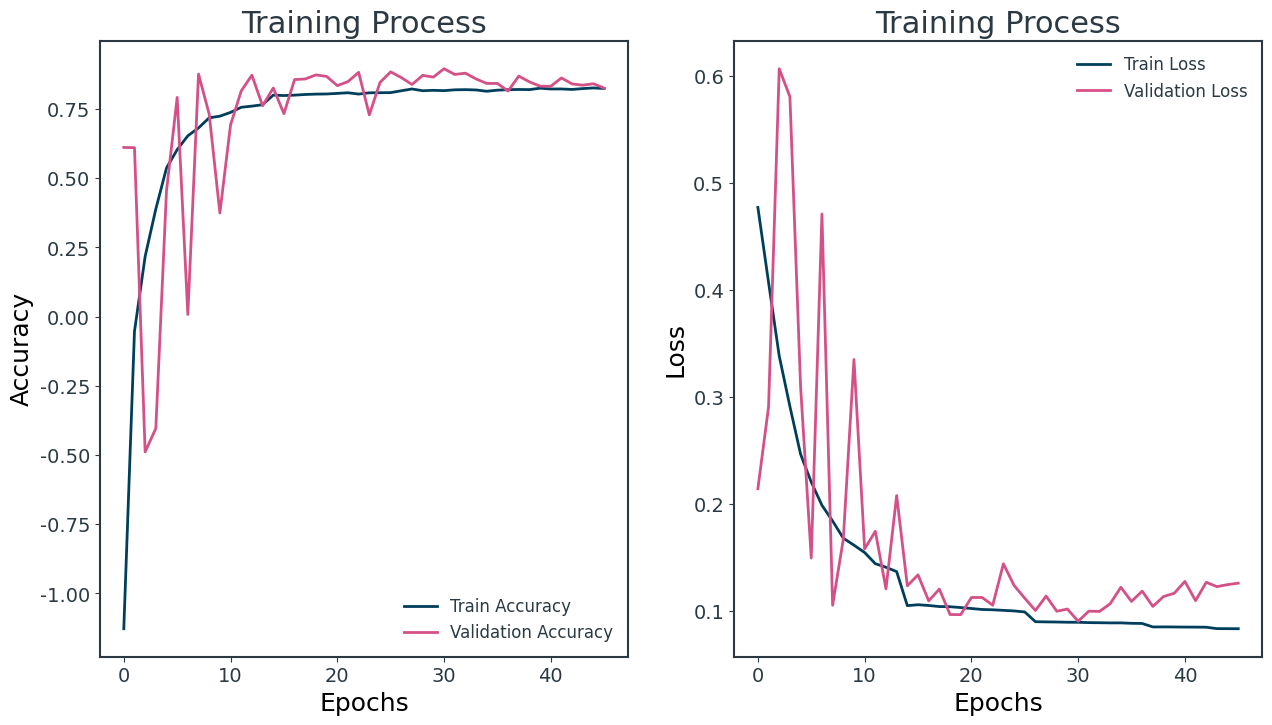

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
model.history.history['r2']

[-1.1273430585861206,
 -0.05311272665858269,
 0.21765905618667603,
 0.38905152678489685,
 0.5371922850608826,
 0.6034844517707825,
 0.6535279750823975,
 0.6819510459899902,
 0.7184968590736389,
 0.7243823409080505,
 0.7380672693252563,
 0.7565552592277527,
 0.7606540322303772,
 0.7658751010894775,
 0.8004233837127686,
 0.7989309430122375,
 0.8003442883491516,
 0.802800178527832,
 0.8041011691093445,
 0.8046186566352844,
 0.8066753149032593,
 0.8089796304702759,
 0.8042141795158386,
 0.8088688850402832,
 0.8090950846672058,
 0.8095019459724426,
 0.8161986470222473,
 0.8226816058158875,
 0.8162901997566223,
 0.817773699760437,
 0.8166101574897766,
 0.8196269869804382,
 0.820219874382019,
 0.819144606590271,
 0.81444251537323,
 0.8183166980743408,
 0.82016921043396,
 0.820850670337677,
 0.8203639984130859,
 0.8253913521766663,
 0.8226013779640198,
 0.8227073550224304,
 0.8209851980209351,
 0.8241168260574341,
 0.8263329863548279,
 0.8245851993560791]

In [14]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.47708192467689514, 0.40711095929145813, 0.3383040428161621, 0.29118314385414124, 0.24660056829452515, 0.22054511308670044, 0.1989094763994217, 0.18422424793243408, 0.1681637465953827, 0.16164125502109528, 0.15474598109722137, 0.1443430781364441, 0.14099669456481934, 0.13692334294319153, 0.10515513271093369, 0.10598962008953094, 0.10529901832342148, 0.10430226475000381, 0.10413870215415955, 0.10333279520273209, 0.10248148441314697, 0.10156265646219254, 0.10126762837171555, 0.10073879361152649, 0.10021760314702988, 0.09923741221427917, 0.09014109522104263, 0.08998064696788788, 0.08984576910734177, 0.08963362872600555, 0.08959558606147766, 0.08929897099733353, 0.08917536586523056, 0.08902794122695923, 0.08903272449970245, 0.0886467844247818, 0.08848374336957932, 0.08525005728006363, 0.08529892563819885, 0.08522026985883713, 0.08512751758098602, 0.08508113026618958, 0.08498977869749069, 0.08367208391427994, 0.083646

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 [==============================] - 15s 896us/step
R2 Score: 0.9046775607741585
MAE: 0.09050910658166851
